# Sentiment Analysis and Prediction in Python

Welcome to your webinar workspace! Here, you can follow along as we try to predict the sentiment of movie reviews!

To consult the solution, head over to the file browser and select `notebook-solution.ipynb`.

The cells below install a package currently unavailable in Workspace and import the libraries we will use in this code. The final cell also imports the data in your directory (`"movie_reviews.csv"`).

In [11]:
%%capture
!pip install wordcloud

In [12]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Load data as a DataFrame
movie=pd.read_csv('movie_reviews.csv')


# Preview the data
movie.sample(3)

,text,label
623,Critics are a strange kind of people. Some of ...,0
351,As someone has already mentioned on this board...,0
2934,Have to be honest and say that I haven't seen ...,1


## Inspect and explore our data
We can inspect the data types and the number of non-null rows per column using the [`.info()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html) method.

In [13]:
# Inspect the data types and non-null rows # no missing
print(movie.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4000 non-null   object
 1   label   4000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 62.6+ KB
None


As this is a classification problem, we will want to inspect the balance of our target variable `label`. We can use [`.value_counts()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) with `normalize` set to `True` to return the proportion of each class label.

In [14]:
# Check the value counts of the sentiment label 1:pso 0 neg 
movie.label.value_counts(normalize=True)

0    0.5085
1    0.4915
Name: label, dtype: float64

One way to inspect our text data is to create a word cloud, which shows the most frequent words by size. To create one, we initialize a [`WordCloud()`](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud). Specifying the stopwords allows us to filter out generic words such as "the" and "and".

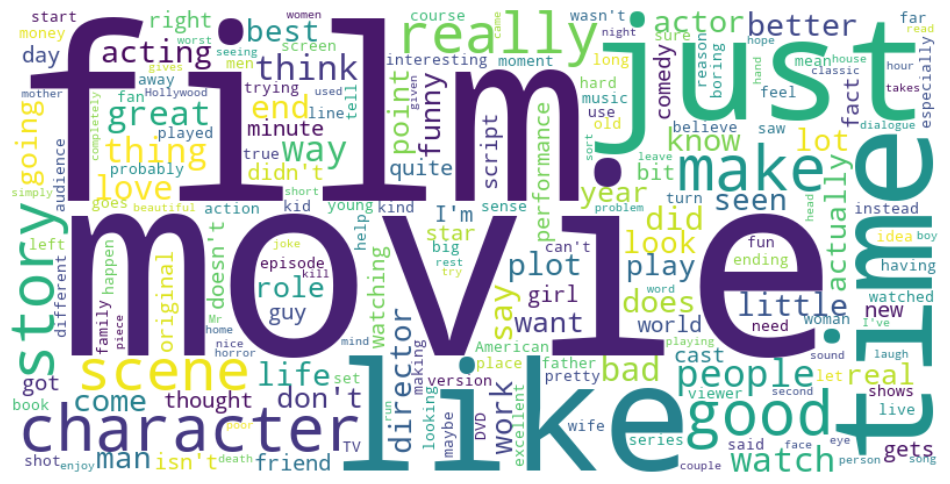

In [15]:
# Concatenate the text review data
df=" ".join(movie['text'])

# Create the word cloud image
WordCloud=WordCloud(background_color='white',
                    stopwords=ENGLISH_STOP_WORDS,
                    width=800,
                    height=400
                    )

# Generate the word cloud using the review data
WordCloud.generate(df)

# Display the word cloud
plt.rcParams['figure.figsize']=(12,8)
plt.imshow(WordCloud , interpolation="bilinear")
plt.axis("off")
plt.show()

## Pre-processing the review text
To pre-process the text, we will use the term frequency-inverse document frequency, or TfIdf. TfIdf is a way of calculating the importance of words in a collection of different sets of text (or documents).
TfIdf has the advantages of:

- Highlighting words that are common within a document but not across documents.
- Returning low scores for words common across all reviews (e.g., movie in movie reviews).
- Penalizing frequent words so we don't need to worry about stop words as much.

Fortunately, Scikit-Learn has a [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class that can convert text data into a set of TfIdf features.

In [18]:
# Specify the word pattern
pattern=r"[a-zA-Z]+"

# Convert frozenset to list
stop_words_list = list(ENGLISH_STOP_WORDS)

# Build the vectorizer and fit to the text data
vect=TfidfVectorizer(token_pattern=pattern , stop_words=stop_words_list , ngram_range=(1,2), max_features=500)

# Create sparse matrix from the vectorizer
tokenized_features=vect.fit_transform(movie['text'])

# Create a DataFrame of the new features
features=pd.DataFrame(data=tokenized_features.toarray() , 
                      columns=vect.get_feature_names_out())

features.head()

,able,absolutely,act,acting,action,actor,actors,actress,actually,add,...,wouldn t,writer,writing,written,wrong,year,year old,years,yes,young
0,0.000000,0.073909,0.077820,0.14043,0.062353,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.086017,...,0.000000,0.0,0.0,0.158546,0.0,0.0,0.0,0.059755,0.080679,0.0
2,0.000000,0.000000,0.000000,0.00000,0.000000,0.109195,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
3,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.151444,0.0,0.000000,0.000000,...,0.220499,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
4,0.138907,0.000000,0.140286,0.00000,0.000000,0.000000,0.097776,0.0,0.201605,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0


Let's add a few more features about the nature of the review, calculating different length metrics for the text (inspired by this [great article](https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d)).

In [19]:
# Generate a number of different length metrics based on the text
movie['char_count']=movie['text'].str.count(r"\S")
movie['Word_count']=movie['text'].str.count(pattern)
movie['avg_word_lenght']=movie['char_count']/movie['Word_count']

# Preview our new columns
movie.sample(3)

,text,label,char_count,Word_count,avg_word_lenght
300,10/10 PLOT DISCUSSION This is one of the best ...,1,4365,940,4.643617
1945,I should have figured that any movie with the ...,0,340,81,4.197531
2785,Are we allowed to interfere with our fellowmen...,1,2352,463,5.079914


## Fit a model and evaluate its performance
Finally, we assign our features and target to `X` and `y`, respectively, split our data into train and test subsets, and fit a classification model to the data.

In this case, we use a simple [`RandomForestClassifier()`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and calculate the classification metrics using the test set and our predicted values.

In [21]:
# Define X and y
X=pd.concat([features,movie.loc[:,'char_count':]] , axis=1)
y=movie["label"]

# Train/test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)


# Train a random forest classifier
model=RandomForestClassifier(
    random_state=42
).fit(X_train,y_train)
# Predict the labels
y_pred=model.predict(X_test)
# Print classification metrics
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       418
           1       0.77      0.79      0.78       382

    accuracy                           0.79       800
   macro avg       0.79      0.79      0.79       800
weighted avg       0.79      0.79      0.79       800



We can also generate a confusion matrix using [`ConfusionMatrixDisplay.from_estimator()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay#sklearn.metrics.ConfusionMatrixDisplay.from_estimator) to gain additional insights into the performance of our classification. This allows us to see what percentage of predictions were true positives, true negatives, false positives, and false negatives.

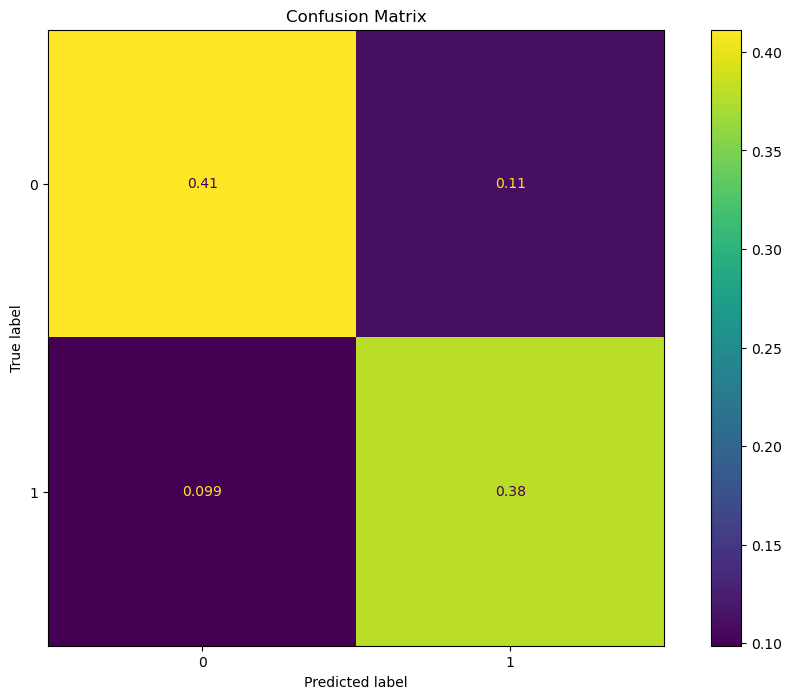

In [22]:
# Print a confusion matrix for the model
ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,normalize="all")
plt.title("Confusion Matrix")
plt.show()

For one final step, let's look at the feature importances to see which words (or features) were most relevant.

In [23]:
# Create a DataFrame of the features and their importances
pd.DataFrame(
    {'features':X.columns ,
     "Importance":model.feature_importances_}
).sort_values(by="Importance" ,ascending=False)

,features,Importance
27,bad,0.042177
487,worst,0.030303
174,great,0.021588
25,awful,0.014601
415,t,0.014076
...,...,...
302,opening,0.000422
117,english,0.000416
122,entire,0.000415
351,room,0.000403


## Wrapping up
Congratulations! We successfully loaded in some review data, inspected it, performed some simple text-processing, and made predictions.